<a href="https://colab.research.google.com/github/serinamarie/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Copy_of_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [0]:
from collections import namedtuple

User = namedtuple('User', ['purchased','time_on_site', 'mobile'])
example_user = User(False, 12, False)
example_user

User(purchased=False, time_on_site=12, mobile=False)

In [0]:
example_user.time_on_site = 30

AttributeError: ignored

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
import numpy as np

np.random.normal(10,2)

12.085154521957202

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4*60, 3*60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  # time_on_site = random.uniform(5, 300)
  time_on_site = np.random.normal(7.5*60, 2.5*60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
users[:10]

[User(purchased=True, time_on_site=691.2356337003489, mobile=True),
 User(purchased=True, time_on_site=718.5968092700543, mobile=True),
 User(purchased=False, time_on_site=398.5209510562585, mobile=True),
 User(purchased=False, time_on_site=237.58953132209214, mobile=True),
 User(purchased=False, time_on_site=498.31458775133456, mobile=True),
 User(purchased=True, time_on_site=356.0733558070021, mobile=True),
 User(purchased=True, time_on_site=334.4156132603532, mobile=True),
 User(purchased=True, time_on_site=539.9564283468009, mobile=True),
 User(purchased=True, time_on_site=778.6191322052503, mobile=True),
 User(purchased=True, time_on_site=427.9397027512876, mobile=True)]

In [44]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,691.235634,True
1,True,718.596809,True
2,False,398.520951,True
3,False,237.589531,True
4,False,498.314588,True


In [0]:
# Convert seconds to minutes (for comparison)
user_data['time_on_site_min'] = user_data['time_on_site'] / 60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,True,691.235634,True,11.520594
1,True,718.596809,True,11.976613
2,False,398.520951,True,6.642016
3,False,237.589531,True,3.959826
4,False,498.314588,True,8.305243


In [0]:
# Find negative time data
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min
198,False,-33.649641,True,-0.560827
553,False,-36.571082,False,-0.609518
561,False,-16.055786,True,-0.267596
641,False,-27.211871,True,-0.453531


In [0]:
# Assign negative time_on_site values to 0.0
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] = 0.0
user_data[user_data.time_on_site < 0.0] # confirm no zeros

,purchased,time_on_site,mobile,time_on_site_min


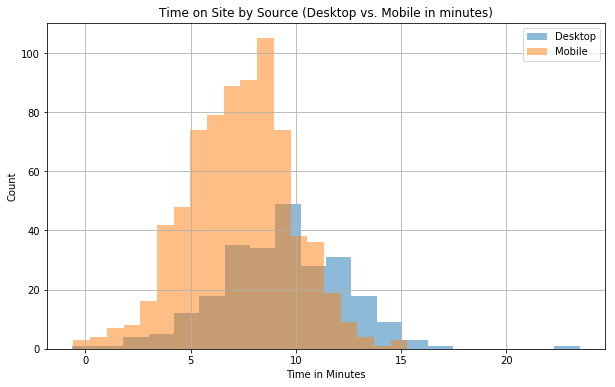

In [0]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5, figsize=(10,6));
plt.title('Time on Site by Source (Desktop vs. Mobile in minutes)');
plt.ylabel('Count')
plt.xlabel('Time in Minutes')
plt.legend(['Desktop','Mobile']);

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,0.0,42.72956590328732,49.414624650041276,51.14584944301464,54.6920175982865,61.05827751550669,62.439095180102925,66.3350329360731,98.11394513028125,99.14955426352623,100.91775883571108,103.72357858769783,106.09726063341839,119.94718054111047,122.83794684574394,124.31143347951524,128.108112108522,137.56282363705947,142.47747808953477,149.22476726180076,150.60103575416184,151.469769960762,152.17875603291037,154.05255895024794,161.02789712987448,163.64540474002547,169.83866435923682,170.8369055863638,170.99375618653045,172.89802947592244,174.95530648347574,175.09264637421268,177.58392112291506,184.01750309428286,186.12585637974058,191.32560473647163,191.89890410390416,197.11826455528796,198.50980426525769,198.66276957505607,...,765.4378581889304,768.5207340238416,768.739752622394,771.1527284418653,772.7089236562518,773.9764516833002,774.1898212214843,778.6191322052503,779.3295596637076,781.6978491545786,783.2303249089516,784.0736138156122,790.3891610935717,801.2267981205962,808.7664272324391,809.8506872727673,813.3432408531826,815.649009795623,819.8858062112873,823.2963930451458,825.696208103712,830.4892320666652,830.9891960322861,832.643198735247,838.3491435496071,839.7958682067085,854.3731974164905,855.3774414658083,872.5360911324603,877.0473809641308,879.1280045684284,882.0223435798047,900.3651948538428,904.9533430112048,909.3421662704758,918.2741130946742,953.7579517283326,973.6212451172458,1045.2602259933176,1409.3738595079167
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,4,1,1,1,1,1,1,0,0,1,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,...,1,0,0,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0
True,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,...,0,1,1,0,0,0,0,1,0,1,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,1,0,0,1,0,0,1,1,1,1


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-0.634, 4.21]",0.120267,0.068966
"(4.21, 9.03]",0.632517,0.564428
"(9.03, 13.85]",0.236080,0.344828
"(13.85, 18.67]",0.011136,0.019964
"(18.67, 23.49]",0.000000,0.001815


In [0]:
pd.crosstab(columns=user_data['purchased'], index=time_bins, normalize='index')

purchased,False,True
time_on_site_min,,
"(-0.634, 4.21]",0.586957,0.413043
"(4.21, 9.03]",0.477311,0.522689
"(9.03, 13.85]",0.358108,0.641892
"(13.85, 18.67]",0.312500,0.687500
"(18.67, 23.49]",0.000000,1.000000


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-0.634, 4.21]",0.120267,0.068966
"(4.21, 9.03]",0.632517,0.564428
"(9.03, 13.85]",0.236080,0.344828
"(13.85, 18.67]",0.011136,0.019964
"(18.67, 23.49]",0.000000,0.001815


In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.552,0.414667
True,0.448,0.585333


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')

purchased            False               True           
mobile               False     True      False     True 
time_on_site_min                                        
(-0.634, 4.21]    0.043478  0.154341  0.044643  0.075171
(4.21, 9.03]      0.492754  0.694534  0.276786  0.637813
(9.03, 13.85]     0.434783  0.147910  0.589286  0.282460
(13.85, 18.67]    0.028986  0.003215  0.080357  0.004556
(18.67, 23.49]    0.000000  0.000000  0.008929  0.000000

In [0]:
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(-0.634, 4.21]",0.120267,0.068966
"(4.21, 9.03]",0.632517,0.564428
"(9.03, 13.85]",0.236080,0.344828
"(13.85, 18.67]",0.011136,0.019964
"(18.67, 23.49]",0.000000,0.001815


## Stanford Open Police Project
https://openpolicing.stanford.edu/findings/

In [0]:
!unzip tr137st9964_mn_saint_paul_2019_02_25.csv.zip


Archive:  tr137st9964_mn_saint_paul_2019_02_25.csv.zip
replace share/data/opp-for-archive/mn_saint_paul_2019_02_25.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

KeyboardInterrupt: ignored

In [0]:
%%time
df = pd.read_csv('./share/data/opp-for-archive/mn_saint_paul_2019_02_25.csv')
print(df.shape)

In [0]:
df.head()

In [0]:
df.isna().sum()

In [0]:
# What are the most common violations?
df.violation.value_counts().head(10)

In [0]:
# What can we infer about vehicle make and likelihood of getting pulled over?
df.vehicle_make.value_counts(normalize=True).head(10)

In [0]:
# What can we infer about this statement? Are other confounding relationships needed (male, female, race, etc.)?
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_make.value_counts(normalize=True).head(10)

In [0]:
# What about vehicle color?
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_color.value_counts(normalize=True).head(10)

## Using %%timeit for Different Pandas Operations

In [0]:
df = pd.DataFrame({'a': np.arange(1e6),
                  'b': 2*np.arange(1e6)})
print(df.shape)
df.head()

In [0]:
%timeit df['c'] = df['a']**2

In [0]:
from tqdm import tqdm
tqdm.pandas()

In [0]:
%timeit df['c2'] = df['a'].apply(lambda x: x**2)

In [0]:
%timeit df['c3'] = df['a'].progress_apply(lambda x: x**2)

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)